In [13]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.models.rotation import RotationEstimator
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
from torch import nn
from sdofm.models import unet
import torch.nn.functional as F



KeyboardInterrupt



In [5]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [6]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
    

In [7]:
year = '2014'
year_end = year
year_start = year
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 2,
    num_workers = 10,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = f'{year_start}-01-01',
    end_date   = f'{year_end}-12-31',
    dim = False,
    sampling_period = '10days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [8]:
pretrained_unet = torch.load("../fm-brightspots/unetmodel_12ch_1classes_bilinear_sizefactor4.ckpt").cuda()

## build dataloader objects

In [ ]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

In [10]:
pretrained_unet.bilinear

True

## buid model  init optimizer

In [11]:
#model = RotationEstimator(pretrained_unet=None).cuda()
#model_name_prefix = "scratch"
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#model = RotationEstimator(pretrained_unet=pretrained_unet).cuda()
#model_name_prefix = "unet_pretrained_full"
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model = RotationEstimator(pretrained_unet=pretrained_unet).cuda()
model_name_prefix = "unet_pretrained_fconly"
optimizer = torch.optim.Adam(model.fc_layers.parameters(), lr=1e-5)

loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

psize = [np.prod(i.shape) for i in model.unet.encoder_layers.parameters()]
print ("encoder parameters        ", sum(psize))

psize = [np.prod(i.shape) for i in model.fc_layers.parameters()]
print ("fc_layers parameters      ", sum(psize))


encoder parameters         590720
fc_layers parameters       8414561


## training loop

In [ ]:
et = ElapsedTimes()
num_epochs = 20
lossh, lossvalh = [], []
predictions, targets = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    try:
        for step, batch in enumerate(dltrain):
            # extract data from batch
            with et("batch"):
                n = len(batch['image_stack'])

                # assumes two timeframes, compute actual time between both timeframes and scales it
                # wrt to the sampling period so that it is in [0,1]
                t = batch['timestamps']
                tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                              for ni in range(n)])\
                                           .reshape(-1,1)\
                                           .cuda()

                image_stack_t0 = batch['image_stack'][:,:,0,:,:].cuda()
                image_stack_t1 = batch['image_stack'][:,:,1,:,:].cuda()

            # run model
            with et("forward"):

                tdeltas_pred = model(image_stack_t0, image_stack_t1)

            # compute loss
            with et("loss"):
                loss = loss_fn(tdeltas_pred,tdeltas_truth)

            # backpropage and sigmoidupdate
            with et("backward"):
                loss.backward()
                optimizer.step()

            """

            for p in tdeltas_pred.detach().cpu().numpy():
                predictions.append(p)

            for t in tdeltas_truth.detach().cpu().numpy():
                targets.append(t)


            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()
            """
            lossvaln = 0.
            with et("logging"):
                # cosmetics
                lossn = loss.detach().cpu().numpy()
                lossh.append(lossn)

                lossvalh.append(lossvaln)


                psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
                lossm = np.mean(lossh[-100:])
                lossvalm = np.mean(lossvalh[-100:])
                epoch_time = (datetime.now() - t0).seconds
                print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")
    except KeyboardInterrupt:
        print ("keyboard interrupt")
        break
    except Exception as e:
        print (e)
        pass
    print()

epoch   0 step 14150 loss 0.20316 lossval 0.00000 params 0.2860810 epoch_time 1263 secs
epoch   1 step 14150 loss 0.17713 lossval 0.00000 params 0.2992588 epoch_time 1273 secs
epoch   2 step 14150 loss 0.17703 lossval 0.00000 params 0.3134128 epoch_time 1278 secs
epoch   3 step 14150 loss 0.12690 lossval 0.00000 params 0.3276532 epoch_time 1297 secs
epoch   4 step 14150 loss 0.16005 lossval 0.00000 params 0.3432920 epoch_time 1298 secs
epoch   5 step 14150 loss 0.17218 lossval 0.00000 params 0.3579115 epoch_time 1305 secs
epoch   6 step 14150 loss 0.13767 lossval 0.00000 params 0.3734619 epoch_time 1306 secs
epoch   7 step 14150 loss 0.15709 lossval 0.00000 params 0.3876067 epoch_time 1293 secs
epoch   8 step 14150 loss 0.15510 lossval 0.00000 params 0.4002200 epoch_time 1307 secs
epoch   9 step 14150 loss 0.16478 lossval 0.00000 params 0.4123524 epoch_time 1311 secs
epoch  10 step 14150 loss 0.14693 lossval 0.00000 params 0.4246640 epoch_time 1315 secs
epoch  11 step 14150 loss 0.1402

In [14]:
1

1

# 

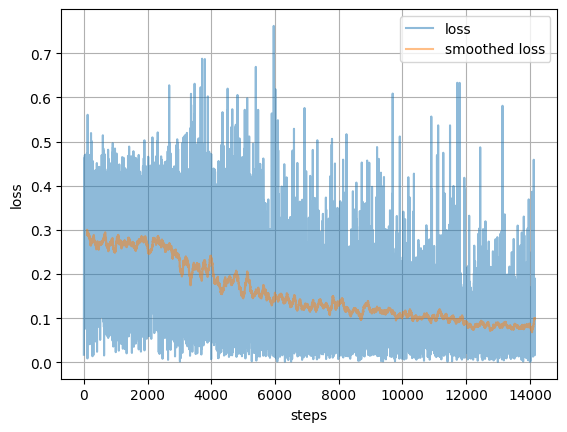

In [15]:
ploth(lossh)

In [16]:
torch.save(model, f"{model_name_prefix}_rotation_estimator_{year}.ckpt")

# performance analysis

In [ ]:
model = torch.load("unet_pretrained_rotation_estimator.ckpt")
def get_predictions(dataloader):

    targets, predictions = [], []
    
    for batch in pbar(dataloader, max_value=len(dataloader)):
        # extract data from batch
        n = len(batch['image_stack'])

        # assumes two timeframes, compute actual time between both timeframes and scales it
        # wrt to the sampling period so that it is in [0,1]
        t = batch['timestamps']
        tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                      for ni in range(n)])\
                                   .reshape(-1,1)
                                   

        image_stack_t0 = batch['image_stack'][:,:,0,:,:].cuda()
        image_stack_t1 = batch['image_stack'][:,:,1,:,:].cuda()

        # run model
        tdeltas_pred = model(image_stack_t0, image_stack_t1).cpu().detach().numpy()

        for p in tdeltas_pred:
            predictions.append(p)
            
        for t in tdeltas_truth:
            targets.append(p)
        
    return targets, predictions

In [ ]:
dlperf = data_module.test_dataloader()
perftargets, perfpreds = get_predictions(dlperf)

In [ ]:
perftargets = np.r_[perftargets].flatten()
perfpreds = np.r_[perfpreds].flatten()
err = np.sqrt((perftargets - perfpreds)**2)


In [131]:
#err_pretrained = np.sqrt((trtargets -trpreds)**2)
import pickle
with open(f"errs-{model_name_prefix}-{year}.pkl", "wb") as f:
    pickle.dump(err, f)

In [134]:
def plot_errs_thresholds(err, label=None, ls="-"):
    err_thresholds = np.linspace(0,1,100)
    err_p = [np.mean(err<t) for t in err_thresholds]
    plt.plot(err_thresholds, err_p, label=label, ls=ls)
    plt.xlabel("prediction error")
    plt.ylabel("pct of imgs with at most err")


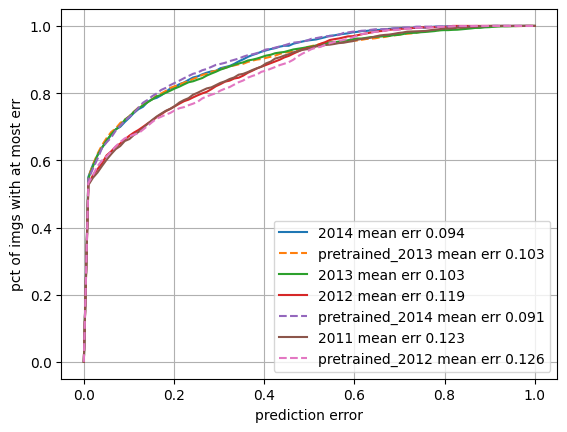

In [137]:
import pickle 
files = [i for i in os.listdir(".") if i.startswith("err")]
for file in files:
    with open(file, "rb") as f:
        k = pickle.load(f)
    ls = '--' if 'pretrained' in file else '-'
    plot_errs_thresholds(k, label=f'{file.split(".")[0].split("-")[-1]} mean err {k.mean():.3f}', ls=ls)
plt.grid()
plt.legend()    

In [139]:
dataloader = data_module.train_dataloader()
for batch in pbar(dataloader, max_value=len(dataloader)):
    # extract data from batch
    n = len(batch['image_stack'])

    # assumes two timeframes, compute actual time between both timeframes and scales it
    # wrt to the sampling period so that it is in [0,1]
    t = batch['timestamps']
    tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                  for ni in range(n)])\
                               .reshape(-1,1)


    image_stack_t0 = batch['image_stack'][:,:,0,:,:].cuda()
    image_stack_t1 = batch['image_stack'][:,:,1,:,:].cuda()
    break
    # run model


  0% (0 of 14151) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

In [166]:
enc0 = model.unet.forward_encode(image_stack_t0).detach().cpu().numpy()
enc1 = model.unet.forward_encode(image_stack_t1).detach().cpu().numpy()
enc0.shape, enc1.shape

((2, 256, 32, 32), (2, 256, 32, 32))

In [167]:
t = batch['timestamps']
tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                              for ni in range(n)])\
                           .reshape(-1,1)\
                           .cuda()
tdeltas_pred = model(image_stack_t0, image_stack_t1).cpu().detach().numpy()


['2014-07-11 09:48:00', '2014-07-15 02:24:00']

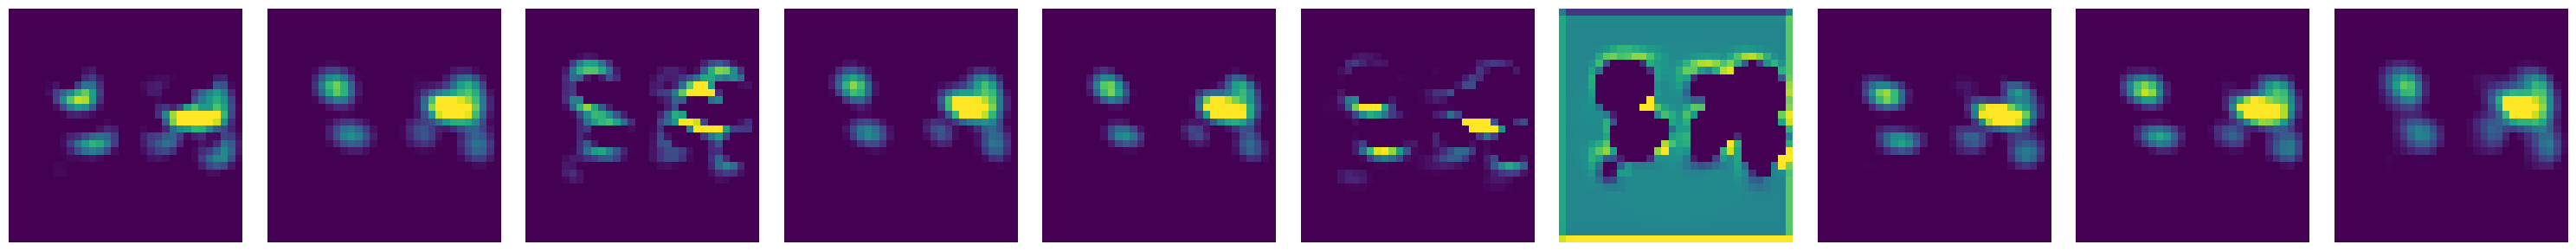

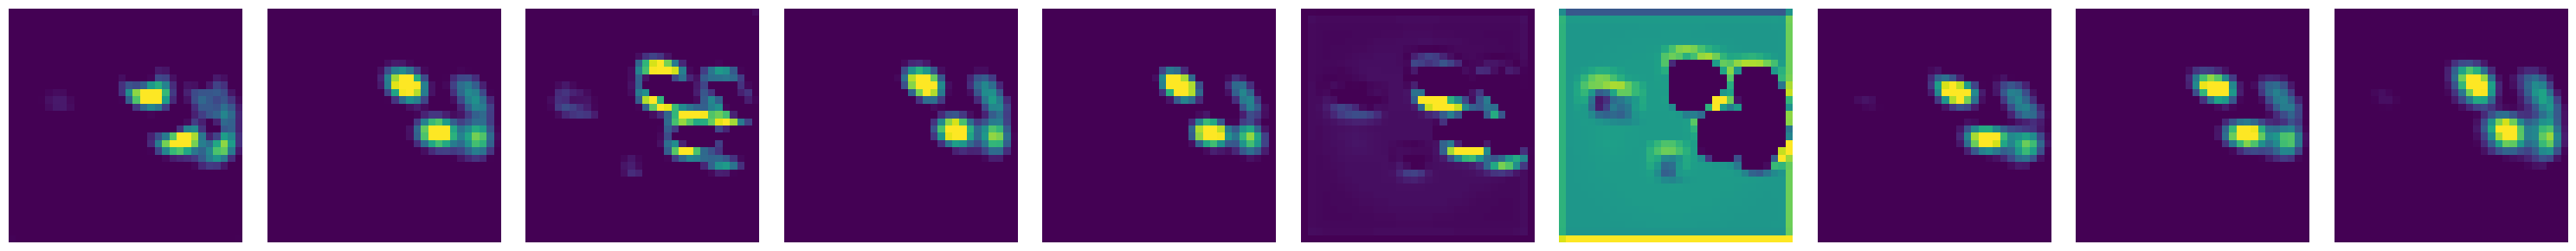

In [168]:
idx = 1
for enc in [enc0, enc1]:
    for ax,i in subplots(10):
        x = enc[idx,i]
        a,b = np.percentile(x, [1,99])
        plt.imshow(x, vmin=a, vmax=b)
        plt.axis("off")
[i[idx] for i in batch['timestamps']]

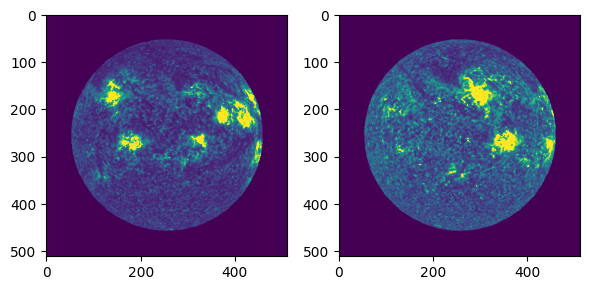

In [169]:
t0 = image_stack_t0.cpu().numpy()
t1 = image_stack_t1.cpu().numpy()
for ax, i in subplots(2):
    if i==0:
        x = t0[idx, 6]
    if i==1:
        x = t1[idx, 6]
    
    a,b=np.percentile(x, [1,99])
    plt.imshow(x, vmin=a, vmax=b)
    plt.imshow(x, vmin=a, vmax=b)

In [157]:
[i[idx] for i in batch['timestamps']]

['2014-08-23 16:00:00', '2014-08-28 10:48:00']